In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [2]:
import numpy as np
import pylab as plt
import networkx as nx
import math as m

cost =1
alpha = 0.6
beta = 0.45454
freq_lambda =  10000 
d = 5000
dmax = 5400
gamma = 0.85

In [3]:
R_sec = alpha *((d/dmax)**0.4)*cost
R_ntwk = (cost/beta)*(m.log(10000,10))
R_net = (R_sec + R_ntwk)
Rmax = 10

In [4]:
class DroneEnv(Env):
    def __init__(self):
        
        # Actions : A0-Remain Stationary, A1-Move, A2- Land at Terminal
        self.action_space = Discrete(3)
        
        # States: S0,S1,S2,S3
        self.observation_space = Box(low=np.array([0]), high=np.array([3]),dtype= np.int32)
  
        # Initial State:
        self.state = 0 + random.randint(-1,1)
        # Hovering time (sec):
        self.hover_length = 80
        
    def step(self, action):
   
        self.state += action -1 
        self.hover_length -= 1 
        
        # Calculate reward
       # if self.state >= and self.state <=S3: 
        #    reward = Rmax 
        #else: 
         #   reward = R_net    
        
        gamma = 0.85 #discount factor

        #Rewards

        if self.state >= 1.5 and self.state <=2.0:
            reward = R_sec
        elif self.state >= 2.0 and self.state <=2.5: 
            reward = R_net
        elif self.state >= 2.5 and self.state <3.0:
            reward = Rmax
        elif self.state == 3.0:
            reward = Rmax
        else:
            reward = -1
            
        reward = reward*gamma
#________________________________________________________________________

    
#_________________________________________________________________________
        # Check if surveillance is done
        if self.hover_length <= 0: 
            done = True
        else:
            done = False
        
        #self.state += random.randint(-1,1)
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset drone's flying state 
        self.state = 1 + random.randint(-1,1)
        # Reset hoverer time
        
        self.hover_length = 15
        return self.state
        


In [5]:
env = DroneEnv()

In [6]:
env.observation_space.sample()

array([0])

In [7]:
env.observation_space.shape

(1,)

In [8]:
episodes = 500
scores = []

for episode in range(episodes):
    state = env.reset()
    done = False
    score = R_net

    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    scores.append(score)
    print('Episode:{} Score:{}'.format(episode, score))

Episode:0 Score:70.1491512320986
Episode:1 Score:44.72645550569968
Episode:2 Score:-3.368083639580094
Episode:3 Score:-3.368083639580094
Episode:4 Score:50.10461208681882
Episode:5 Score:-2.023544494300309
Episode:6 Score:66.11553379625926
Episode:7 Score:18.08276866793796
Episode:8 Score:3.3546120868188285
Episode:9 Score:-3.368083639580094
Episode:10 Score:-3.368083639580094
Episode:11 Score:19.365533796259243
Episode:12 Score:43.4436903773784
Episode:13 Score:11.360072941539046
Episode:14 Score:8.670994650979475
Episode:15 Score:46.070994650979465
Episode:16 Score:28.71553379625926
Episode:17 Score:0.6655337962592603
Episode:18 Score:59.45461208681883
Episode:19 Score:-3.368083639580094
Episode:20 Score:68.80461208681882
Episode:21 Score:-3.368083639580094
Episode:22 Score:0.6655337962592603
Episode:23 Score:-0.6790053490205246
Episode:24 Score:3.3546120868188303
Episode:25 Score:63.48822952265819
Episode:26 Score:54.07645550569968
Episode:27 Score:22.054612086818832
Episode:28 Scor

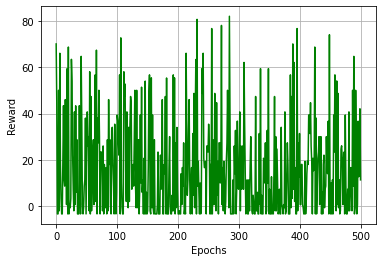

In [9]:

plt.plot(scores,'g-')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid(b=None, which='major', axis='both')
plt.show()


# Building the Neural Network

In [10]:


import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


In [11]:
states = env.observation_space.shape
actions = env.action_space.n


In [12]:
actions = env.action_space.n
print(actions)

3


In [13]:
env.observation_space.shape

(1,)

In [14]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(54, activation='relu', input_shape=states))
    model.add(Dense(54, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [20]:
model = build_model(states, actions)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 54)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 54)                2970      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 165       
Total params: 3,243
Trainable params: 3,243
Non-trainable params: 0
_________________________________________________________________


In [17]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [18]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [21]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=0.01), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 12:33 - reward: 0.4945

C:\Users\singh\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\singh\anaconda3\lib\site-packages\rl\memory.py:40: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 98s 10ms/step - reward: 6.6782
666 episodes - episode_reward: 100.172 [-12.750, 127.500] - loss: 245.131 - mae: 56.992 - mean_q: 87.125

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: 6.9844
667 episodes - episode_reward: 104.778 [-12.750, 127.500] - loss: 295.962 - mae: 64.832 - mean_q: 98.579

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 95s 9ms/step - reward: 7.1348
667 episodes - episode_reward: 107.007 [-12.750, 127.500] - loss: 291.286 - mae: 64.010 - mean_q: 98.416

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: 7.32890s - re
666 episodes - episode_reward: 109.940 [11.328, 127.500] - loss: 301.214 - mae: 64.324 - mean_q: 99.642

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: 4.3901
done, took 509.126 seconds


In [23]:
scores = dqn.test(env, nb_episodes=500, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 500 episodes ...
Episode 1: reward: 127.500, steps: 15
Episode 2: reward: 119.495, steps: 15
Episode 3: reward: 127.500, steps: 15
Episode 4: reward: 127.500, steps: 15
Episode 5: reward: 119.495, steps: 15
Episode 6: reward: 119.495, steps: 15
Episode 7: reward: 110.145, steps: 15
Episode 8: reward: 127.500, steps: 15
Episode 9: reward: 119.495, steps: 15
Episode 10: reward: 119.495, steps: 15
Episode 11: reward: 127.500, steps: 15
Episode 12: reward: 110.145, steps: 15
Episode 13: reward: 119.495, steps: 15
Episode 14: reward: 119.495, steps: 15
Episode 15: reward: 127.500, steps: 15
Episode 16: reward: 110.145, steps: 15
Episode 17: reward: 110.145, steps: 15
Episode 18: reward: 110.145, steps: 15
Episode 19: reward: 119.495, steps: 15
Episode 20: reward: 110.145, steps: 15
Episode 21: reward: 119.495, steps: 15
Episode 22: reward: 119.495, steps: 15
Episode 23: reward: 127.500, steps: 15
Episode 24: reward: 127.500, steps: 15
Episode 25: reward: 119.495, steps: 15
Episo

Episode 216: reward: 119.495, steps: 15
Episode 217: reward: 119.495, steps: 15
Episode 218: reward: 110.145, steps: 15
Episode 219: reward: 110.145, steps: 15
Episode 220: reward: 110.145, steps: 15
Episode 221: reward: 110.145, steps: 15
Episode 222: reward: 127.500, steps: 15
Episode 223: reward: 110.145, steps: 15
Episode 224: reward: 127.500, steps: 15
Episode 225: reward: 110.145, steps: 15
Episode 226: reward: 119.495, steps: 15
Episode 227: reward: 119.495, steps: 15
Episode 228: reward: 119.495, steps: 15
Episode 229: reward: 119.495, steps: 15
Episode 230: reward: 127.500, steps: 15
Episode 231: reward: 127.500, steps: 15
Episode 232: reward: 119.495, steps: 15
Episode 233: reward: 127.500, steps: 15
Episode 234: reward: 127.500, steps: 15
Episode 235: reward: 119.495, steps: 15
Episode 236: reward: 110.145, steps: 15
Episode 237: reward: 110.145, steps: 15
Episode 238: reward: 119.495, steps: 15
Episode 239: reward: 127.500, steps: 15
Episode 240: reward: 110.145, steps: 15


Episode 425: reward: 127.500, steps: 15
Episode 426: reward: 127.500, steps: 15
Episode 427: reward: 110.145, steps: 15
Episode 428: reward: 127.500, steps: 15
Episode 429: reward: 127.500, steps: 15
Episode 430: reward: 110.145, steps: 15
Episode 431: reward: 110.145, steps: 15
Episode 432: reward: 110.145, steps: 15
Episode 433: reward: 127.500, steps: 15
Episode 434: reward: 110.145, steps: 15
Episode 435: reward: 119.495, steps: 15
Episode 436: reward: 119.495, steps: 15
Episode 437: reward: 119.495, steps: 15
Episode 438: reward: 110.145, steps: 15
Episode 439: reward: 110.145, steps: 15
Episode 440: reward: 127.500, steps: 15
Episode 441: reward: 127.500, steps: 15
Episode 442: reward: 110.145, steps: 15
Episode 443: reward: 127.500, steps: 15
Episode 444: reward: 110.145, steps: 15
Episode 445: reward: 110.145, steps: 15
Episode 446: reward: 127.500, steps: 15
Episode 447: reward: 119.495, steps: 15
Episode 448: reward: 119.495, steps: 15
Episode 449: reward: 110.145, steps: 15


In [50]:
print(scores)

In [127]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

Testing for 15 episodes ...
Episode 1: reward: 119.495, steps: 15
Episode 2: reward: 127.500, steps: 15
Episode 3: reward: 119.495, steps: 15
Episode 4: reward: 127.500, steps: 15
Episode 5: reward: 119.495, steps: 15
Episode 6: reward: 110.145, steps: 15
Episode 7: reward: 110.145, steps: 15
Episode 8: reward: 127.500, steps: 15
Episode 9: reward: 110.145, steps: 15
Episode 10: reward: 127.500, steps: 15
Episode 11: reward: 127.500, steps: 15
Episode 12: reward: 110.145, steps: 15
Episode 13: reward: 110.145, steps: 15
Episode 14: reward: 119.495, steps: 15
Episode 15: reward: 119.495, steps: 15


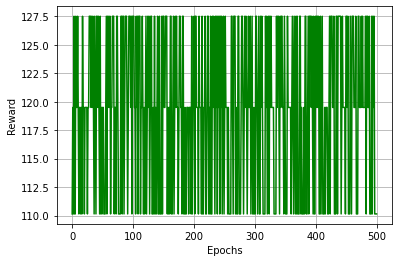

In [51]:
plt.plot(scores.history['episode_reward'],'g-')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid(b=None, which='major', axis='both')
plt.show()

In [53]:

scores = dqn.test(env, nb_episodes=200, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 200 episodes ...
Episode 1: reward: 110.145, steps: 15
Episode 2: reward: 119.495, steps: 15
Episode 3: reward: 127.500, steps: 15
Episode 4: reward: 127.500, steps: 15
Episode 5: reward: 127.500, steps: 15
Episode 6: reward: 110.145, steps: 15
Episode 7: reward: 119.495, steps: 15
Episode 8: reward: 110.145, steps: 15
Episode 9: reward: 119.495, steps: 15
Episode 10: reward: 110.145, steps: 15
Episode 11: reward: 127.500, steps: 15
Episode 12: reward: 110.145, steps: 15
Episode 13: reward: 127.500, steps: 15
Episode 14: reward: 119.495, steps: 15
Episode 15: reward: 110.145, steps: 15
Episode 16: reward: 127.500, steps: 15
Episode 17: reward: 110.145, steps: 15
Episode 18: reward: 110.145, steps: 15
Episode 19: reward: 127.500, steps: 15
Episode 20: reward: 127.500, steps: 15
Episode 21: reward: 119.495, steps: 15
Episode 22: reward: 127.500, steps: 15
Episode 23: reward: 110.145, steps: 15
Episode 24: reward: 127.500, steps: 15
Episode 25: reward: 127.500, steps: 15
Episo

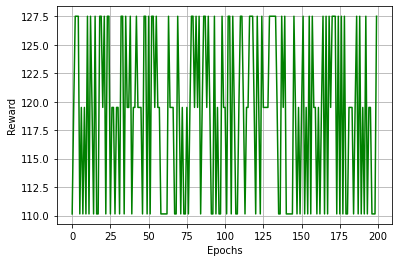

In [54]:
plt.plot(scores.history['episode_reward'],'g-')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid(b=None, which='major', axis='both')
plt.show()